In [1]:
import numpy as np
import pandas as pd
import math
import statsmodels.formula.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy as sp
from scipy import stats as st
from scipy.stats import gamma, lognorm, multivariate_normal, norm, t
import seaborn as sbn
import importlib
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, 'code/synthetic_data_and_moea_plots/')

### Project functions ###
import functions_clean_data
import functions_synthetic_data
import functions_revenues_contracts

sbn.set_style('white')
sbn.set_context('paper', font_scale=1.55)

cmap = cm.get_cmap('viridis')
col = [cmap(0.1),cmap(0.3),cmap(0.6),cmap(0.8)]

N_SAMPLES = 1000000
eps = 1e-13

dir_downloaded_inputs = './data/downloaded_inputs/'
dir_generated_inputs = './data/generated_inputs/'
dir_figs = './figures/'

### Get and clean data
# SWE
importlib.reload(functions_clean_data)
swe = functions_clean_data.get_clean_swe(dir_downloaded_inputs)[['danFeb','danApr']]

# gen
# gen = functions_clean_data.get_historical_generation(dir_downloaded_inputs, swe).reset_index()

#sweSynth 
sweSynth = functions_synthetic_data.synthetic_swe(dir_generated_inputs, swe, redo = False, save = False)

In [2]:
# hydro generation (GWh/mnth)
gen = functions_clean_data.get_historical_generation(dir_downloaded_inputs, swe).reset_index()

# wholesale power price ($/MWh), inflation adjusted
power = functions_clean_data.get_historical_power(dir_downloaded_inputs)

# SFPUC fin year sales and rates
hp_GWh, hp_dolPerKwh, hp_dolM = functions_clean_data.get_historical_SFPUC_sales()




### Generate synthetic time series
# # SWE, Feb 1 & Apr 1
importlib.reload(functions_synthetic_data)
sweSynth = functions_synthetic_data.synthetic_swe(dir_generated_inputs, swe, redo = False, save = False)

# monthly generation, dependent on swe. Will also create fig S2, showing fitted models (gen as fn of swe) for each month.
genSynth = functions_synthetic_data.synthetic_generation(dir_generated_inputs, dir_figs, gen, sweSynth,
                                                         redo = False, save = False, plot = False)


# monthly power price
importlib.reload(functions_synthetic_data)
powSynth = functions_synthetic_data.synthetic_power(dir_generated_inputs, power, redo = False, save = False)



importlib.reload(functions_revenues_contracts)
revHist, powHistSample, revSim = functions_revenues_contracts.simulate_revenue(dir_generated_inputs, gen, hp_GWh,
                                                                           hp_dolPerKwh, genSynth, powSynth,
                                                                           redo = False, save = False)


# get index from swe/revenue relationship.
nYr = int(len(revSim) / 12)
yrSim = np.full((1, nYr * 12), 0)
for i in range(1, nYr):
  yrSim[0, (12 * i):(12 * (i + 1))] = i
revSimWyr = revSim.groupby(yrSim[0, :(nYr * 12)]).sum()
revHistWyr = revHist.groupby('wyear').sum()
genSynthWyr = genSynth.groupby(yrSim[0, :(nYr * 12)]).sum()
genHistWyr = gen.groupby(yrSim[0, :len(powHistSample)]).sum()
powSynthWyr = powSynth.groupby(yrSim[0, :(nYr * 12)]).mean()
powHistWyr = powHistSample.groupby(yrSim[0, :len(powHistSample)]).mean()

lmRevSWE = sm.ols(formula='rev ~ sweFeb + sweApr', data=pd.DataFrame(
  {'rev': revSimWyr.values, 'sweFeb': sweSynth.danFeb.values,
   'sweApr': sweSynth.danApr.values}))
lmRevSWE = lmRevSWE.fit()
# print(lmRevSWE.summary())

sweWtParams = [lmRevSWE.params[1]/(lmRevSWE.params[1]+lmRevSWE.params[2]), lmRevSWE.params[2]/(lmRevSWE.params[1]+lmRevSWE.params[2])]
sweWtSynth = (sweWtParams[0] * sweSynth.danFeb + sweWtParams[1] * sweSynth.danApr)

/home/andrew/projects/hamilton-2020-managing-financial-risk-tradeoffs-for-hydropower/.venv_tradeoffs/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [3]:
payoutFebSim = functions_revenues_contracts.snow_contract_payout(dir_generated_inputs, sweSynth.danFeb, contractType = 'cfd',
                                                               label='Feb', lambdaRisk = 0.25, strikeQuantile = 0.5,
                                                               capQuantile = 0.95, redo = True, save = True)
payoutAprSim = functions_revenues_contracts.snow_contract_payout(dir_generated_inputs, sweSynth.danApr, contractType = 'cfd',
                                                               label='Apr', lambdaRisk = 0.25, strikeQuantile = 0.5,
                                                               capQuantile = 0.95, redo = True, save = True)

In [4]:
# print(payoutAprSim.head())
payoutCfdSim = functions_revenues_contracts.snow_contract_payout(dir_generated_inputs, sweWtSynth, contractType = 'cfd',
                                                               lambdaRisk = 0.25, strikeQuantile = 0.5,
                                                               capQuantile = 0.95, redo = True, save = False)
# print(payoutCfdSim.head())

/home/andrew/projects/hamilton-2020-managing-financial-risk-tradeoffs-for-hydropower/.venv_tradeoffs/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/andrew/projects/hamilton-2020-managing-financial-risk-tradeoffs-for-hydropower/.venv_tradeoffs/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/andrew/projects/hamilton-2020-managing-financial-risk-tradeoffs-for-hydropower/.venv_tradeoffs/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


In [5]:
### fixed cost parameters
meanRevenue = np.mean(revSimWyr)
fixedCostFraction =  0.914
### get historical swe, gen, power price, revenue, net revenue. Period of record for hydropower = WY 1988-2016
historical_data = pd.DataFrame({'sweFeb': swe.loc[revHistWyr.index,:].danFeb, 'sweApr': swe.loc[revHistWyr.index,:].danApr})
historical_data['gen'] = genHistWyr.tot.values/1000
powHistWyr.index = revHistWyr.index
historical_data['pow'] = powHistWyr
historical_data['rev'] = revHistWyr.rev
historical_data['netrev'] = historical_data['rev'] - (meanRevenue * fixedCostFraction)
# get unit swe payout for historic data
def payout(swe_value, kinkX, kinkY):
    if (swe_value >= kinkX):
        return kinkY 
    else:
        return kinkY + (kinkX - swe_value)
kinkY = np.min(payoutFebSim)
kinkX = np.min(sweSynth.danFeb.loc[payoutFebSim < kinkY + eps])
historical_data['cfdFeb'] = [payout(x, kinkX, kinkY) for x in historical_data['sweFeb']]
kinkY = np.min(payoutAprSim)
kinkX = np.min(sweSynth.danApr.loc[payoutAprSim < kinkY + eps])
historical_data['cfdApr'] = [payout(x, kinkX, kinkY) for x in historical_data['sweApr']]

historical_data.index = np.arange(1988, 2017)
historical_data.to_csv(dir_generated_inputs + 'historical_data.csv')

# read in lambdas from LHC sample
importlib.reload(functions_revenues_contracts)
param_list = pd.read_csv(dir_generated_inputs + 'param_LHC_sample.txt', sep=' ',
                         header=None, names=['c','delta','Delta_fund','Delta_debt','lam'])
# get premium shift for each lambda in dataset
lam_prem_shift = functions_revenues_contracts.snow_contract_payout_shift_lambda(sweSynth.danFeb,
                                                                     param_list.lam.values, contractType = 'cfd',
                                                                     lambdaRisk = 0.25, strikeQuantile = 0.5)
param_list['lam_prem_shift_Feb'] = lam_prem_shift
lam_prem_shift = functions_revenues_contracts.snow_contract_payout_shift_lambda(sweSynth.danApr,
                                                                     param_list.lam.values, contractType = 'cfd',
                                                                     lambdaRisk = 0.25, strikeQuantile = 0.5)
param_list['lam_prem_shift_Apr'] = lam_prem_shift
param_list.to_csv(dir_generated_inputs + 'param_LHC_sample_withLamPremShift.txt', sep=' ', header=True, index=False)


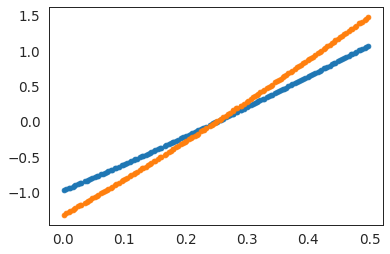

In [6]:
plt.scatter(param_list.lam, param_list.lam_prem_shift_Feb)
plt.scatter(param_list.lam, param_list.lam_prem_shift_Apr)

plt.figure()
plt.

In [7]:
functions_revenues_contracts.save_synthetic_data_moea(dir_generated_inputs, sweSynth, revSimWyr, payoutFebSim, payoutAprSim)
